<h1><center> Foursquare Location Matching </center></h1>
<h2><center> Baseline Modeling </center></h2>
<h2><center> Sugata Ghosh </center></h2>

### Competition: [Foursquare - Location Matching](https://www.kaggle.com/competitions/foursquare-location-matching)

### Notebook on Exploratory Data Analysis: [Foursquare Location Matching - EDA](https://www.kaggle.com/code/sugataghosh/foursquare-location-matching-eda)

The present notebook compares several baseline models to classify whether two given [points of interest](https://en.wikipedia.org/wiki/Point_of_interest) (POI) match or not. We have considered the following features:
- **Distance between locations** (in km), computed from the information on latitude and longitude of locations, using the [haversine formula](https://en.wikipedia.org/wiki/Haversine_formula)
- **Similarity measures for several string-type features**, based on proportion of the length of **largest common substring** of two given strings, to the length of the shorter string
- **Matching of countries**, based on [ISO 3166-1 alpha-2](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2) country codes

### Contents

- Introduction
- Train-Test Split
- Data Preprocessing
- Feature Engineering
- Baseline Modeling
- Acknowledgements
- References

### Importing libraries

In [1]:
# File system manangement
import time, psutil, os, gc

# Mathematical functions
import math
from math import cos, asin, sqrt, pi

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Train-test split and k-fold cross validation
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Others
import operator as op
from functools import reduce, lru_cache

### Runtime and memory usage

In [2]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

# 1. Introduction

- Point of Interest
- The Problem of POI Matching
- About Foursquare
- Data
- Project Objective
- Evaluation Metric
- Working with Pairs Set

**Note:** The introduction section from the [Foursquare Location Matching - EDA](https://www.kaggle.com/code/sugataghosh/foursquare-location-matching-eda) notebook is reproduced here to make the present notebook self-contained, so that one can understand the problem, as well as the objective of the competition, without requiring to go back to the EDA notebook.

## Point of Interest

A point of interest (POI) is a specific point location that someone may find useful or interesting. An example is a point on the Earth representing the location of the Eiffel Tower, or a point on Mars representing the location of its highest mountain, [Olympus Mons](https://en.wikipedia.org/wiki/Olympus_Mons). Most consumers use the term when referring to hotels, campsites, fuel stations or any other categories used in modern automotive navigation systems. Users of a mobile device can be provided with geolocation and time aware POI service that recommends geolocations nearby and with a temporal relevance (e.g. POI to special services in a ski resort are available only in winter). The notion of POI is widely used in cartography, especially in electronic variants including GIS, and GPS navigation software.

## The Problem of POI Matching

It is useful to combine POI data obtained from multiple sources for effective reusability. One issue in merging such data is that different dataset may have variations in POI name, address, and other identifying information for the same POI. It is thus important to identify observations which refer to the same POI. The process of POI matching involves finding POI pairs that refer to the same real-world entity, which is the core issue in geospatial data integration and is perhaps the most technically difficult part of multi-source POI fusion. The raw location data can contain noise, unstructured information, and incomplete or inaccurate attributes, which makes the task even more difficult. Nonetheless, to maintain the highest level of accuracy, the data must be matched and duplicate POIs must be identified and merged with timely updates from multiple sources. A combination of machine-learning algorithms and rigorous human validation methods are optimal for effective de-duplication of such data.

## About Foursquare

[Foursquare Labs Inc.](https://foursquare.com/), commonly known as Foursquare, is an American location technology company and data cloud platform. The company's location platform is the foundation of several business and consumer products, including the [Foursquare City Guide](https://en.wikipedia.org/wiki/Foursquare_City_Guide) and [Foursquare Swarm](https://en.wikipedia.org/wiki/Foursquare_Swarm) apps. Foursquare's products include Pilgrim SDK, Places, Visits, Attribution, Audience, Proximity, and Unfolded Studio. It is one of the leading independent providers of global POI data and is dedicated to building meaningful bridges between digital spaces and physical places. Trusted by leading enterprises like Apple, Microsoft, Samsung, and Uber, Foursquare's tech stack harnesses the power of places and movement to improve customer experiences and drive better business outcomes.

## Data

**Source:** https://www.kaggle.com/competitions/foursquare-location-matching/data

The data considered in the competition comprises over one-and-a-half million place entries for hundreds of thousands of commercial Points-of-Interest (POIs) around the globe. Though the data entries may represent or resemble entries for real places, they may be contaminated with artificial information or additional noise.

The training data comprises eleven attribute fields for over one million place entries, together with:
- `id` : A unique identifier for each entry.
- `point_of_interest` : An identifier for the POI the entry represents. There may be one or many entries describing the same POI. Two entries *match* when they describe a common POI.

In [3]:
# Loading the training data
data_train = pd.read_csv('../input/foursquare-location-matching/train.csv')
print(pd.Series({"Memory usage": "{:.2f} MB".format(data_train.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data_train.shape)}).to_string())
print(" ")
data_train.head()

Memory usage         112.95 MB
Dataset shape    (1138812, 13)
 


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb


In [4]:
# A typical observation from the training set
data_train.iloc[0]

id                       E_000001272c6c5d
name                 Café Stad Oudenaarde
latitude                        50.859975
longitude                        3.634196
address                       Abdijstraat
city                           Nederename
state                     Oost-Vlaanderen
zip                                  9700
country                                BE
url                                   NaN
phone                                 NaN
categories                           Bars
point_of_interest        P_677e840bb6fc7e
Name: 0, dtype: object

The pairs data is a pregenerated set of pairs of place entries from the training data designed to improve detection of matches. It includes:
- `match` : Boolean variables denoting whether or not the pair of entries describes a common POI.

In [5]:
# Loading pregenerated set of pairs of place entries from the training data
data_pairs = pd.read_csv('../input/foursquare-location-matching/pairs.csv')
print(pd.Series({"Memory usage": "{:.2f} MB".format(data_pairs.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data_pairs.shape)}).to_string())
print(" ")
data_pairs.head()

Memory usage        106.55 MB
Dataset shape    (578907, 25)
 


,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,...,3.635206,NaN,NaN,NaN,NaN,BE,NaN,NaN,Bars,True
1,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,...,27.845560,batı aydın,aydın,NaN,67500,TR,NaN,NaN,Electronics Stores,False
2,E_000023d8f4be44,Island Spa,14.518970,121.018702,"5th Flr, Newport Mall, Resorts World Manila",Pasay City,Metro Manila,NaN,PH,NaN,...,121.019827,NaN,NaN,NaN,NaN,PH,NaN,NaN,Spas,True
3,E_00007dcd2bb53f,TOGO'S Sandwiches,38.257797,-122.064599,"1380 Holiday Ln., Ste. B",Fairfield,CA,94534,US,https://locations.togos.com/ll/US/CA/Fairfield...,...,-122.064606,NaN,Fairfield,CA,NaN,US,NaN,NaN,Sandwich Places,True
4,E_0000c362229d93,Coffee Cat,7.082218,125.610244,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,...,125.611457,E. Jacinto Extension,Davao City,Davao Region,8000,PH,NaN,NaN,"Coffee Shops, Cafés, Dessert Shops",False


In [6]:
# A typical observation from the pregenerated set of pairs
data_pairs.iloc[0]

id_1                E_000001272c6c5d
name_1          Café Stad Oudenaarde
latitude_1                 50.859975
longitude_1                 3.634196
address_1                Abdijstraat
city_1                    Nederename
state_1              Oost-Vlaanderen
zip_1                           9700
country_1                         BE
url_1                            NaN
phone_1                          NaN
categories_1                    Bars
id_2                E_da7fa3963561f8
name_2               Café Oudenaarde
latitude_2                 50.869358
longitude_2                 3.635206
address_2                        NaN
city_2                           NaN
state_2                          NaN
zip_2                            NaN
country_2                         BE
url_2                            NaN
phone_2                          NaN
categories_2                    Bars
match                           True
Name: 0, dtype: object

The test data comprises a set of place entries with their recorded attribute fields, similar to the training set. The POIs in the test data are distinct from the POIs in the training data.

In [7]:
# Loading the test data
data_test = pd.read_csv('../input/foursquare-location-matching/test.csv')
print(pd.Series({"Memory usage": "{:.5f} MB".format(data_test.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data_test.shape)}).to_string())
print(" ")
data_test.head()

Memory usage     0.00058 MB
Dataset shape       (5, 12)
 


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories
0,E_00001118ad0191,Jamu Petani Bagan Serai,5.012169,100.535805,NaN,NaN,NaN,NaN,MY,NaN,NaN,Cafés
1,E_000020eb6fed40,Johnny's Bar,40.434209,-80.564160,497 N 12th St,Weirton,WV,26062.0,US,NaN,NaN,Bars
2,E_00002f98667edf,QIWI,47.215134,39.686088,"Межевая улица, 60",Ростов-на-Дону,NaN,NaN,RU,https://qiwi.com,7.800301e+10,ATMs
3,E_001b6bad66eb98,"Gelora Sriwijaya, Jaka Baring Sport City",-3.014675,104.794374,NaN,NaN,NaN,NaN,ID,NaN,NaN,Stadiums
4,E_0283d9f61e569d,Stadion Gelora Sriwijaya,-3.021727,104.788628,Jalan Gubernur Hasan Bastari,Palembang,South Sumatra,11480.0,ID,NaN,NaN,Soccer Stadiums


In [8]:
# A typical observation from the test set
data_test.iloc[0]

id                   E_00001118ad0191
name          Jamu Petani Bagan Serai
latitude                     5.012169
longitude                  100.535805
address                           NaN
city                              NaN
state                             NaN
zip                               NaN
country                            MY
url                               NaN
phone                             NaN
categories                      Cafés
Name: 0, dtype: object

## Project Objective

The goal of the project is to match POIs together. Using the provided dataset of over one-and-a-half million places entries, heavily altered to include noise, duplications, extraneous, or incorrect information, the objective is to produce an algorithm that predicts which place entries represent the same POI. Each place entry in the data includes useful attributes like name, street address, and coordinates. Efficient and successful matching of POIs will make it easier to identify where new stores or businesses would benefit people the most.

## Evaluation Metric

**[Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index).** Also known as *Jaccard similarity coefficient*, it is a statistic used for gauging the similarity and diversity of sample sets. It was developed by [Grove Karl Gilbert](https://en.wikipedia.org/wiki/Grove_Karl_Gilbert) in 1884 as his *ratio of verification (v)* and now is frequently referred to as the *Critical Success Index* in meteorology. It was later developed independently by [Paul Jaccard](https://en.wikipedia.org/wiki/Paul_Jaccard), originally giving the French name *coefficient de communauté* and independently formulated again by T. T. Tanimoto. Thus, the *Tanimoto index* or *Tanimoto coefficient* are also used in some fields. However, they are identical in generally taking the ratio of Intersection over Union. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

$$ J(A, B) := \frac{\left\vert A \cap B \right\vert}{\left\vert A \cup B \right\vert} = \frac{\left\vert A \cap B \right\vert}{\left\vert A \right\vert + \left\vert B \right\vert - \left\vert A \cap B \right\vert}. $$

Note that by design, $0\leq J\left(A, B\right)\leq 1$. If $A$ and $B$ are both empty, define $J(A, B) = 1$. The Jaccard coefficient is widely used in computer science, ecology, genomics, and other sciences, where binary or binarized data are used. Both the exact solution and approximation methods are available for hypothesis testing with the Jaccard coefficient. See [this paper](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3118-5) ([arxiv version](https://arxiv.org/abs/1903.11372)) for details.

Let us assume that for a specific `id` $a$, our algorithm produces three matches $a$, $b$ and $c$ whereas the true matches are $a$, $b$, $d$ and $e$. Then the Jaccard index for the prediction on this particular `id` will be

$$ \frac{\left\vert \left\{a, b, c\right\} \cap \left\{a, b, d, e\right\} \right\vert}{\left\vert \left\{a, b, c\right\} \cup \left\{a, b, d, e\right\} \right\vert} = \frac{\left\vert \left\{a, b\right\} \right\vert}{\left\vert \left\{a, b, c, d, e\right\} \right\vert} = \frac{2}{5}. $$

Thus, while correct matching predictions are rewarded, incorrect matching predictions are penalised by equal measure. The evaluation metric is simply the mean of Jaccard indices for each of the test observations, i.e. if the test data comprises $n_{\text{test}}$ observations and $J_i$ denotes the Jaccard index corresponding to the $i$th test observation, $i = 1,2,\cdots,n_{\text{test}}$, then the final metric by which a model will be evaluated is:

$$ \frac{1}{n_{\text{test}}} \sum_{i=1}^{n_{\text{test}}} J_i. $$

**Note:** In this notebook, we shall rely solely on the provided pairs set `data_pairs` to build the baseline models.

# 2. Train-Test Split

We split `data_pairs` into two parts:
- `data_pairs_train`: The portion of data that we use to *train* the models
- `data_pairs_test`: The portion of data that we use to *test* or evaluate the models

We shall keep `data_test`, which has only five observations, separate from the modeling procedure.

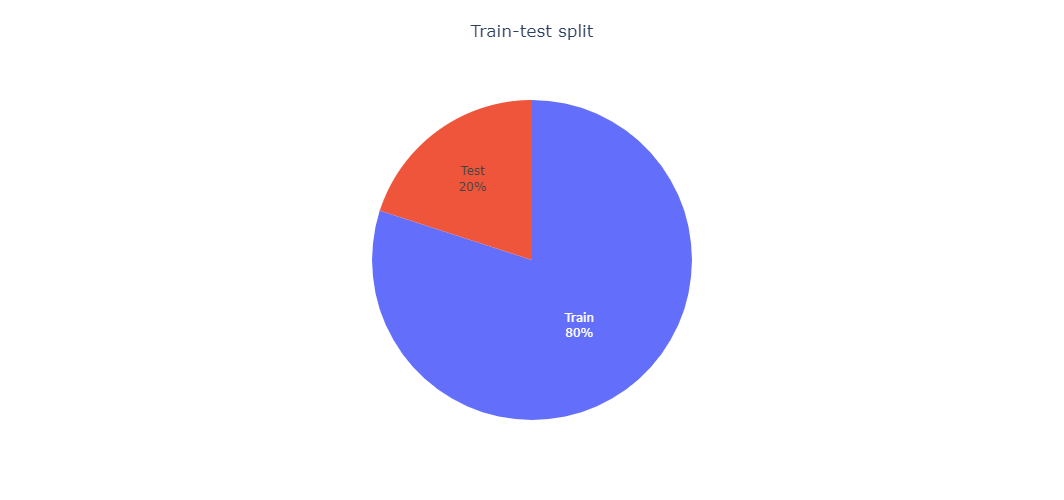

In [9]:
# Splitting data_train
data_pairs_train, data_pairs_test = train_test_split(data_pairs, test_size = 0.2, random_state = 40)

labels = ['Train','Test']
values = [len(data_pairs_train), len(data_pairs_test)]
fig_data = [go.Pie(values = values, labels = labels, hole = 0.0, textinfo = 'label+percent')]
fig_title = dict(text = "Train-test split", x = 0.5, y = 0.95)
fig = go.Figure(data = fig_data)
fig.update_layout(height = 500, width = 800, showlegend = False, title = fig_title)
fig.show()

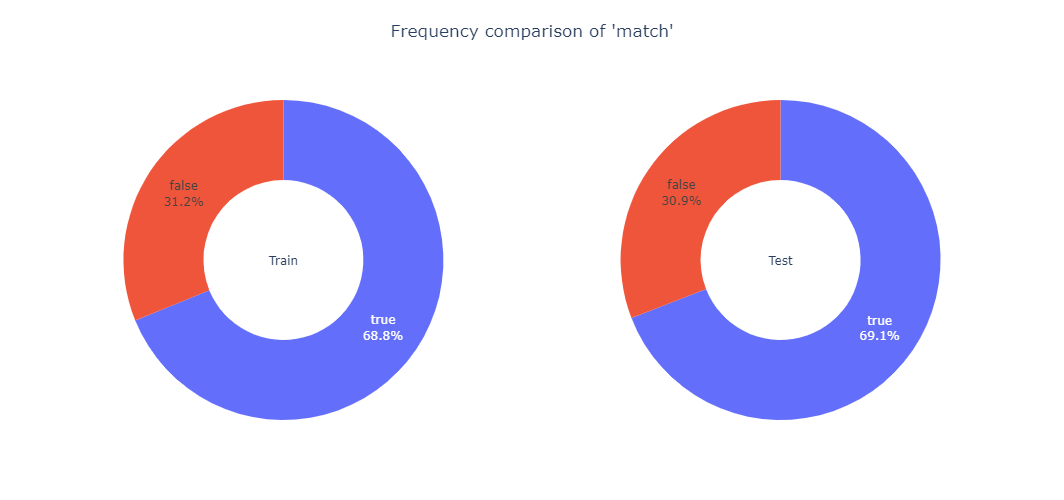

In [10]:
# Donutplots of the 'match' column
fig = make_subplots(rows = 1, cols = 2, specs = [[{'type': 'domain'}, {'type': 'domain'}]])
x_val_train = data_pairs_train['match'].value_counts(sort = False).index.tolist()
y_val_train = data_pairs_train['match'].value_counts(sort = False).tolist()
x_val_test = data_pairs_test['match'].value_counts(sort = False).index.tolist()
y_val_test = data_pairs_test['match'].value_counts(sort = False).tolist()
fig.add_trace(go.Pie(values = y_val_train, labels = x_val_train, hole = 0.5, textinfo = 'label+percent', title = "Train"), row = 1, col = 1)
fig.add_trace(go.Pie(values = y_val_test, labels = x_val_test, hole = 0.5, textinfo = 'label+percent', title = "Test"), row = 1, col = 2)
fig.update_layout(height = 500, width = 800, showlegend = False, xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1), title = dict(text = "Frequency comparison of 'match'", x = 0.5, y = 0.95)) 
fig.show()

We observe that in both the `data_pairs_train` and the `data_pairs_test`, the count of pairs that match is higher than the count of pairs that do not match. However, the imbalance is not too big.

# 3. Data Preprocessing

- Decoding States Abbreviations
- Conversion to Lowercase
- Missing Data Imputation

## Decoding States Abbreviations

In [11]:
# Dictionary of US states abbreviations and names
url_abbrev_to_name = "https://raw.githubusercontent.com/sugatagh/Foursquare-Location-Matching/main/JSON/US_states_abbrev_to_name.json"
dict_abbrev_to_name = pd.read_json(url_abbrev_to_name, typ = 'series')
dict_abbrev_to_name

AL                           Alabama
AK                            Alaska
AS                    American Samoa
AZ                           Arizona
AR                          Arkansas
CA                        California
CO                          Colorado
CT                       Connecticut
DE                          Delaware
DC              District Of Columbia
FM    Federated States Of Micronesia
FL                           Florida
GA                           Georgia
GU                              Guam
HI                            Hawaii
ID                             Idaho
IL                          Illinois
IN                           Indiana
IA                              Iowa
KS                            Kansas
KY                          Kentucky
LA                         Louisiana
ME                             Maine
MH                  Marshall Islands
MD                          Maryland
MA                     Massachusetts
MI                          Michigan
M

In [12]:
# Converting US states abbreviations to names
data_pairs_train.replace({'state_1': dict_abbrev_to_name}, inplace = True)
data_pairs_train.replace({'state_2': dict_abbrev_to_name}, inplace = True)
data_pairs_test.replace({'state_1': dict_abbrev_to_name}, inplace = True)
data_pairs_test.replace({'state_2': dict_abbrev_to_name}, inplace = True)

## Conversion to Lowercase

We convert all alphabetical characters in the relevant object-type columns to lowercase so that the models do not differentiate identical words due to [case sensitivity](https://en.wikipedia.org/wiki/Case_sensitivity).

In [13]:
# Converting to lowercase
def convert_to_lowercase_skipna(x):
    """
    Converts a given string to lowercase
    Arg:
      x (string/NaN): input string (possibly NaN due to missing value)
      
    Returns:
      y (string/NaN): x.lower() if x is not NaN, x otherwise
    """
    if str(x) == 'nan':
        y = x
    else:
        y = x.lower()
    return y

text = "Mobile Phone Shops"
print("Input: {}".format(text))
print("Output: {}".format(convert_to_lowercase_skipna(text)))

Input: Mobile Phone Shops
Output: mobile phone shops


Before applying this conversion, we have to ensure that the argument is of `string` type. However, we do not want to convert the `nan` values to the string `'nan'`, as the converted string will no longer be identified as a missing value, and hence will go unaltered in the *missing value imputation* step.

In [14]:
# Converting to string, unless the argument is nan
def convert_to_string_skipna(x):
    """
    Converts an input to string if it is not NaN, otherwise it is left unaltered
    Arg:
      x (any python data type): input to be converted (possibly NaN due to missing value)
      
    Returns:
      y (str/NaN): str(x) if x is not NaN, x otherwise
    """
    if str(x) == 'nan':
        y = x
    else:
        y = str(x)
    return y

number = 40
print("Input: {}".format(number))
print("Output:")
convert_to_string_skipna(number)

Input: 40
Output:


'40'

We convert the columns `name`, `address`, `city`, `state` and `categories`. We leave the column `url` as it is, for its case sensitivity.

In [15]:
# Applying the conversion to object columns
cols_lower = ['name', 'address', 'city', 'state', 'categories']
cols_lower_pairs = ['name_1', 'address_1', 'city_1', 'state_1', 'categories_1',
                    'name_2', 'address_2', 'city_2', 'state_2', 'categories_2']
for col in cols_lower:
    data_test[col] = data_test[col].apply(convert_to_string_skipna).apply(convert_to_lowercase_skipna)
for col in cols_lower_pairs:
    data_pairs_train[col] = data_pairs_train[col].apply(convert_to_string_skipna).apply(convert_to_lowercase_skipna)
    data_pairs_test[col] = data_pairs_test[col].apply(convert_to_string_skipna).apply(convert_to_lowercase_skipna)

## Missing Data Imputation

In [16]:
# Columns with missing values in the training set with respective proportion of missing values
(data_pairs_train.isna().sum()[data_pairs_train.isna().sum() != 0] / len(data_pairs_train)).sort_values(ascending = False)

url_2           0.853133
phone_2         0.794230
zip_2           0.611343
url_1           0.599376
phone_1         0.533266
state_2         0.465008
address_2       0.459878
zip_1           0.379079
city_2          0.365215
state_1         0.218349
address_1       0.178813
categories_2    0.131114
city_1          0.113622
categories_1    0.028105
country_1       0.000015
country_2       0.000011
dtype: float64

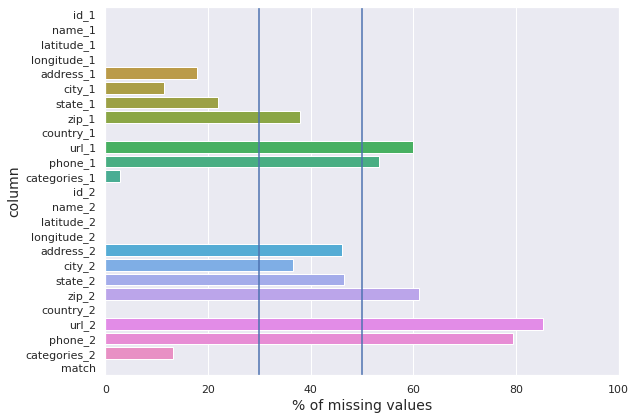

In [17]:
# Missing values in the training set
plt.figure(figsize = (9, 6))
df_temp = data_pairs_train.isna().sum() * 100 / len(data_pairs_train)
s = sns.barplot(x = df_temp.values, y = df_temp.index)
s.set_xlim(0, 100)
s.set_xlabel("% of missing values", fontsize = 14)
s.set_ylabel("column", fontsize = 14)
plt.axvline(x = 30)
plt.axvline(x = 50)
plt.tight_layout()
plt.show()

Seven columns `zip_1`, `url_1`, `phone_1`, `address_2`, `zip_2`, `url_2` and `phone_2` have over $30\%$ values missing. We shall drop these columns from the subsequent analysis.

#### Dropping columns with more than 30% missing values

Even though `address_1` has less than $30\%$ missing values, `address_2` has a very high proportion of it. For a comparison purpose, `address_1` cannot contribute anything alone because *one hand cannot clap*. Thus we drop it alongside all the columns with more than $30\%$ missing values.

In [18]:
# Dropping columns with more than 30% missing values in the training set
cols_drop = ['address', 'zip', 'url', 'phone']
cols_drop_pairs = ['address_1', 'zip_1', 'url_1', 'phone_1', 'address_2', 'zip_2', 'url_2', 'phone_2']
data_test.drop(cols_drop, axis = 1, inplace = True)
data_pairs_train.drop(cols_drop_pairs, axis = 1, inplace = True)
data_pairs_test.drop(cols_drop_pairs, axis = 1, inplace = True)

#### Imputing missing values with 'unknown'

In [19]:
# Imputing missing names with 'unknown'
cols_unknown = ['name', 'city', 'state', 'country']
for col in cols_unknown:
    data_test[col].fillna('unknown', inplace = True)
cols_unknown_pairs = ['name_1', 'city_1', 'state_1', 'country_1', 'name_2', 'city_2', 'state_2', 'country_2']
for col in cols_unknown_pairs:
    data_pairs_train[col].fillna('unknown', inplace = True)
    data_pairs_test[col].fillna('unknown', inplace = True)

#### Mode imputation for categories

In [20]:
# Mode imputation for categories
data_test['categories'].fillna(data_test['categories'].mode()[0], inplace = True)
data_pairs_train['categories_1'].fillna(data_pairs_train['categories_1'].mode()[0], inplace = True)
data_pairs_train['categories_2'].fillna(data_pairs_train['categories_2'].mode()[0], inplace = True)
data_pairs_test['categories_1'].fillna(data_pairs_test['categories_1'].mode()[0], inplace = True)
data_pairs_test['categories_2'].fillna(data_pairs_test['categories_2'].mode()[0], inplace = True)

In [21]:
# Count of missing values in the 'data_pairs_train'
data_pairs_train.isna().sum()

id_1            0
name_1          0
latitude_1      0
longitude_1     0
city_1          0
state_1         0
country_1       0
categories_1    0
id_2            0
name_2          0
latitude_2      0
longitude_2     0
city_2          0
state_2         0
country_2       0
categories_2    0
match           0
dtype: int64

In [22]:
# Count of missing values in the 'data_pairs_test'
data_pairs_test.isna().sum()

id_1            0
name_1          0
latitude_1      0
longitude_1     0
city_1          0
state_1         0
country_1       0
categories_1    0
id_2            0
name_2          0
latitude_2      0
longitude_2     0
city_2          0
state_2         0
country_2       0
categories_2    0
match           0
dtype: int64

In [23]:
# Count of missing values in the true test set
data_test.isna().sum()

id            0
name          0
latitude      0
longitude     0
city          0
state         0
country       0
categories    0
dtype: int64

# 4. Feature Engineering

- Distance between Locations
- Features Based on Largest Common Substring
- Matching of Countries
- The Target Variable

Each row in `data_pairs_train` or `data_pairs_test` consists of two training observations and a `match` variable which indicates whether the two observations match or not. As we have seen in the previous section, an observation in the pairs set can be represented as:

$$ \left(a_1,a_2,\ldots,a_n; b_1,b_2,\ldots,b_n; y\right), $$

where $a_1,a_2,\ldots,a_n$ is the observed features of the first observation, $b_1,b_2,\ldots,b_n$ is the same for the second observation and $y$ is the `match` variable. Now, suppose that $\left(c_1,c_2,\ldots,c_n\right)$ and $\left(d_1,d_2,\ldots,d_n\right)$ are two observations from the `test set`. To predict whether these two observations refer to the same POI or not, we have to predict the corresponding `match` variable $y$. The general idea in this section is to construct a vector of features $\left(z_1,z_2,\ldots,z_m\right)$, with $m \leq n$, which captures the key information about $y$, contained in $\left(c_1,c_2,\ldots,c_n; d_1,d_2,\ldots,d_n\right)$. The goal of the current section is to produce a function that takes in a pair of observations, in the form of $\left(a_1,a_2,\ldots,a_n; b_1,b_2,\ldots,b_n\right)$, as an input and produce $\left(z_1,z_2,\ldots,z_m\right)$ as an output, i.e.

$$ \left(a_1,a_2,\ldots,a_n; b_1,b_2,\ldots,b_n\right) \mapsto \left(z_1,z_2,\ldots,z_m\right). $$

In [24]:
# Typical observation from the 'data_pairs_train'
data_pairs_train.iloc[0]

id_1                                         E_fb3a4b8d0beda6
name_1          platja de son martorell nou / la ciutat jardí
latitude_1                                          39.552824
longitude_1                                          2.689925
city_1                                      son martorell nou
state_1                                         illes balears
country_1                                                  ES
categories_1                              beaches, surf spots
id_2                                         E_03d8da0c589805
name_2                                    platja cuitat jardi
latitude_2                                            39.5512
longitude_2                                          2.690656
city_2                                                unknown
state_2                                               unknown
country_2                                                  ES
categories_2                                          beaches
match   

It contains a pair of observations. The *id* of the two observations are expectedly different. The *name* is slightly different, as are the *latitude* and *longitude*. *Country* and *category* are identical. Some of the attributes are missing in one of the observations, while some are missing in both. The target variable here is `match`, which is a Boolean variable taking the value `True` if the two observations refer to the same POI and `False` otherwise. We observe that the number of features can be greatly reduced if we focus on the information that are relevant in predicting `match`, and discard the rest. We initiate a dataframe to extract and store these relevant information out of the attributes in `data_pairs`.

In [25]:
# Dataframe initialization for new features
df_train = pd.DataFrame()
df_test = pd.DataFrame()

## Distance between Locations

The information that is relevant in predicting `match`, contained in `latitude_1`, `longitude_1`, `latitude_2` and `longitude_2`, can be encapsulted into a single variable, which is the distance `dist_loc` between the two locations (`latitude_1`, `longitude_1`) and (`latitude_2`, `longitude_2`), given by the haversine formula. Let $\left(\phi_1, \lambda_1\right)$ and $\left(\phi_2, \lambda_2\right)$ be the coordinates of two POIs. Then the distance between the two POIs is

$$ d = 2r \arcsin\left(\sqrt{\text{hav}\left(\phi_1 - \phi_2\right) + \text{cos}\left(\phi_1\right) \text{cos}\left(\phi_2\right) \text{hav}\left(\lambda_1 - \lambda_2\right)}\right), $$

where

$$ \text{hav}\left(\theta\right) = \sin^2\left(\frac{\theta}{2}\right) = \frac{1-\cos{\theta}}{2}. $$

In [26]:
# Haversine formula
def dist(lat1, lon1, lat2, lon2):
    """
    Computes the distance (over the surface) between two coordinates (lat1, lon1) and (lat2, lon2)
    Args:
      lat1 (float): latitude of first location
      lon1 (float): longitude of first location
      lat2 (float): latitude of second location
      lon2 (float): longitude of second location
      
    Returns:
      d (float): distance between the two locations in km
    """
    r = 6371
    lat1, lon1, lat2, lon2 = np.radians(lat1), np.radians(lon1), np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat1 - lat2, lon1 - lon2
    h = ((1 - cos(dlat)) / 2) + (cos(lat1) * cos(lat2) * ((1 - cos(dlon)) / 2))
    d = 2 * r * asin(sqrt(h))
    return d

lat1, lon1, lat2, lon2 = 5.012169, 100.535805, 40.434209, -80.564160
print(f"Input: ({lat1}, {lon1}) and ({lat2}, {lon2})")
print(f"Output: {dist(lat1, lon1, lat2, lon2)} km")

Input: (5.012169, 100.535805) and (40.434209, -80.56416)
Output: 14960.43102103062 km


In [27]:
# Distance between locations
dist_loc_train = [dist(data_pairs_train['latitude_1'][i], data_pairs_train['longitude_1'][i], data_pairs_train['latitude_2'][i], data_pairs_train['longitude_2'][i]) for i in data_pairs_train.index]
dist_loc_test = [dist(data_pairs_test['latitude_1'][i], data_pairs_test['longitude_1'][i], data_pairs_test['latitude_2'][i], data_pairs_test['longitude_2'][i]) for i in data_pairs_test.index]
df_train['dist_loc'] = dist_loc_train
df_test['dist_loc'] = dist_loc_test

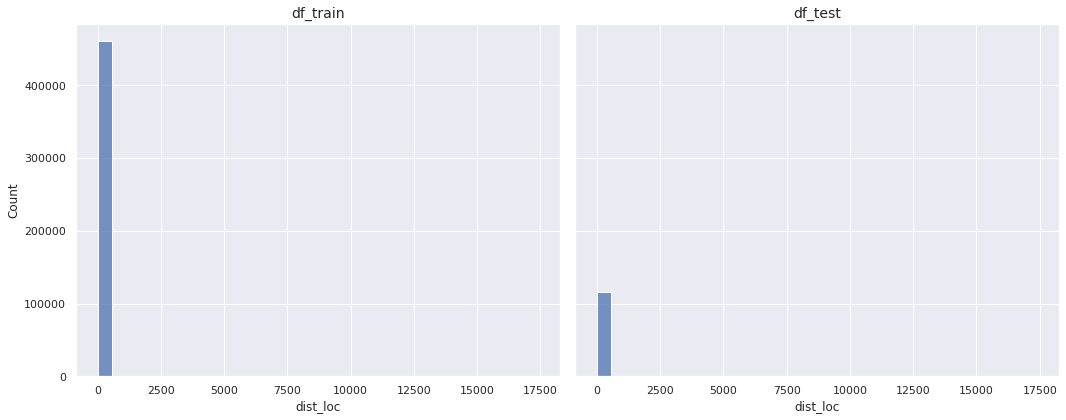

In [28]:
# Histogram of 'dist_loc' for 'df_train' and 'df_test'
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = True)
sns.histplot(data = df_train, x = 'dist_loc', bins = 30, ax = ax[0])
sns.histplot(data = df_test, x = 'dist_loc', bins = 30, ax = ax[1])
ax[0].set_title("df_train", fontsize = 14)
ax[1].set_title("df_test", fontsize = 14)
ax[1].set_ylabel("")
plt.tight_layout()
plt.show()

In both `df_train` and `df_test`, `dist_loc` is concentrated near $0$. It is likely that in both `df_train` and `df_test`, `dist_loc` is positively skewed to an extreme degree. To elaborate, [Skewness](https://en.wikipedia.org/wiki/Skewness) quantifies the asymmetry of a distribution about its mean. It is given by

$$ g_1 := \frac{\frac{1}{n}\sum_{i=1}^n\left(x_i-\bar{x}\right)^3}{\left[\frac{1}{n}\sum_{i=1}^n\left(x_i-\bar{x}\right)^2\right]^{3/2}}, $$

where $\bar{x}$ is the mean of the observations, given by $\bar{x} = \frac{1}{n}\sum_{i=1}^n x_i$. The measure $g_1$ can be negative, zero, positive. A value close to $0$ suggests that the distribution is more or less symmetric. However, as it deviates from $0$, it becomes more and more skewed (either positively or negatively). A positive skewness indicates that the distribution is concentrated towards the left side, with the longer tail being on the right side. A negative skewness indicates that the distribution is concentrated towards the right side, with the longer tail being on the left side. We back up the observation about skewness of `dist_loc` in `df_train` and `df_test` by computing the corresponding $g_1$ values.

In [29]:
# Skewness of 'dist_loc'
print(pd.Series({"Skewness of 'dist_loc' in 'df_train'": df_train['dist_loc'].skew(),
                 "Skewness of 'dist_loc' in 'df_test'": df_test['dist_loc'].skew()}).to_string())

Skewness of 'dist_loc' in 'df_train'    38.784602
Skewness of 'dist_loc' in 'df_test'     37.426394


To deal with the extreme skewness, we have applied the following transformation:

$$ x \mapsto log(x+\epsilon), $$

where $\epsilon$ is a very small positive real number. Here we have taken $\epsilon = 0.00000001$. The reason behind making this small shift to the data is that the log function maps $0$ to $-\infty$. The shift keeps the transformed data finite, and keeping $\epsilon$ small ensures that the data points which were originally $0$, stands out from the rest in the transformed setup. Visualizations of the distribution of both the original feature and the transformed feature have been shown.

In [30]:
# Applying the transformation
epsilon = 0.00000001
df_train['dist_loc_transformed'] = df_train['dist_loc'].apply(lambda x: np.log(x + epsilon))
df_test['dist_loc_transformed'] = df_test['dist_loc'].apply(lambda x: np.log(x + epsilon))

In [31]:
# Deleting old features
df_train.drop('dist_loc', axis = 1, inplace = True)
df_test.drop('dist_loc', axis = 1, inplace = True)

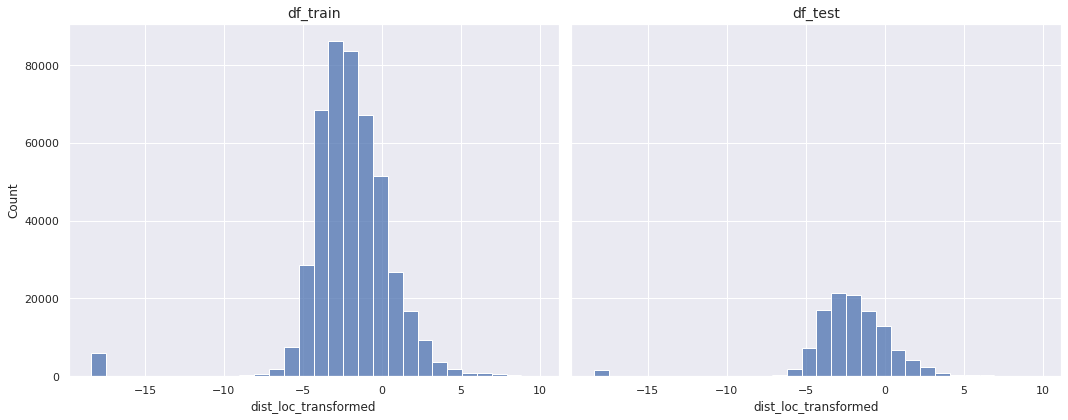

In [32]:
# Histogram of 'dist_loc_transformed' for 'df_train' and 'df_test'
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = True)
sns.histplot(data = df_train, x = 'dist_loc_transformed', bins = 30, ax = ax[0])
sns.histplot(data = df_test, x = 'dist_loc_transformed', bins = 30, ax = ax[1])
ax[0].set_title("df_train", fontsize = 14)
ax[1].set_title("df_test", fontsize = 14)
ax[1].set_ylabel("")
plt.tight_layout()
plt.show()

## Features Based on Largest Common Substring

We observe that, in `data_pairs_train` and `data_pairs_test`, the name for the same POI varies in different records for variety of reasons. For example, some records may contain shortened versions of the names. Similar phenomenon is observed in the city, state and categories attribute. For these reasons, we create similarity features based on these attributes using the length of the largest common substring of two strings, relative to the length of the shorter string. Note that we have to convert some of the input data to string format before feeding it to the function that computes this quantity.

In [33]:
# Relative length proportion of largest common substring of two strings
def lcss(str1, str2):
    """
    Computes length proportion of largest common substring of two strings, relative to the length of the shorter string
    Args:
      str1 (string): a general string
      str2 (string): a general string

    Returns:
      prop (float): length of the largest common substring of two strings, scaled by length of the shorter string
    """
    n1, n2 = len(str1), len(str2)
    lc = [[0 for k in range(n2 + 1)] for l in range(n1 + 1)]
    out = 0
    for i in range(n1 + 1):
        for j in range(n2 + 1):
            if (i == 0 or j == 0):
                lc[i][j] = 0
            elif (str1[i-1] == str2[j-1]):
                lc[i][j] = lc[i-1][j-1] + 1
                out = max(out, lc[i][j])
            else:
                lc[i][j] = 0
    prop = out / min(n1, n2)
    return prop

str1, str2 = '118th street bus stop', '118th street beach'
print(f"Input: '{str1}' and '{str2}'")
print(f"Output: {lcss(str1, str2)}")

Input: '118th street bus stop' and '118th street beach'
Output: 0.7777777777777778


In [34]:
%%time
# Relative length of largest common substring between names, cities, states and categories
lcss_name_train, lcss_name_test = [], []
lcss_city_train, lcss_city_test = [], []
lcss_state_train, lcss_state_test = [], []
lcss_categories_train, lcss_categories_test = [], []
for i in data_pairs_train.index:
    lcss_name_train.append(lcss(data_pairs_train['name_1'][i], data_pairs_train['name_2'][i]))
    lcss_city_train.append(lcss(data_pairs_train['city_1'][i], data_pairs_train['city_2'][i]))
    lcss_state_train.append(lcss(data_pairs_train['state_1'][i], data_pairs_train['state_2'][i]))
    lcss_categories_train.append(lcss(data_pairs_train['categories_1'][i], data_pairs_train['categories_2'][i]))
for i in data_pairs_test.index:
    lcss_name_test.append(lcss(data_pairs_test['name_1'][i], data_pairs_test['name_2'][i]))
    lcss_city_test.append(lcss(data_pairs_test['city_1'][i], data_pairs_test['city_2'][i]))
    lcss_state_test.append(lcss(data_pairs_test['state_1'][i], data_pairs_test['state_2'][i]))
    lcss_categories_test.append(lcss(data_pairs_test['categories_1'][i], data_pairs_test['categories_2'][i]))
df_train['lcss_name'], df_test['lcss_name'] = lcss_name_train, lcss_name_test
df_train['lcss_city'], df_test['lcss_city'] = lcss_city_train, lcss_city_test
df_train['lcss_state'], df_test['lcss_state'] = lcss_state_train, lcss_state_test
df_train['lcss_categories'], df_test['lcss_categories'] = lcss_categories_train, lcss_categories_test

CPU times: user 5min 50s, sys: 364 ms, total: 5min 50s
Wall time: 5min 50s


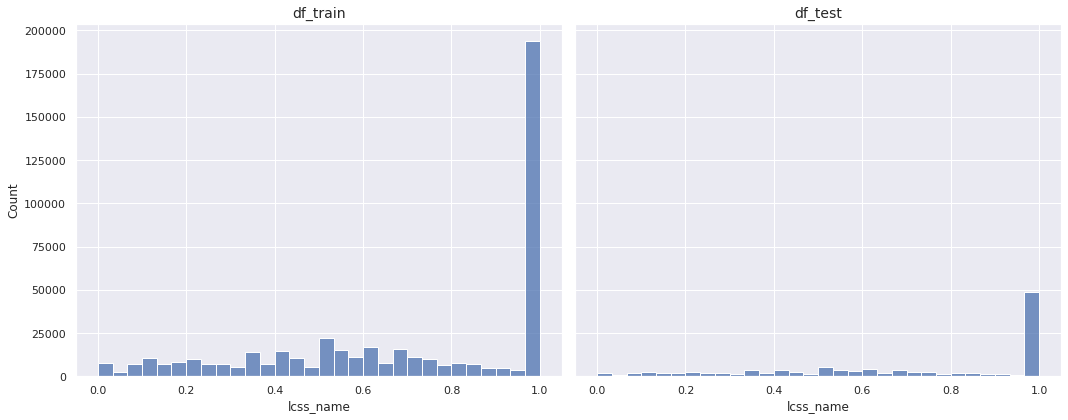

In [35]:
# Histogram of 'lcss_name' for 'df_train' and 'df_test'
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = True)
sns.histplot(data = df_train, x = 'lcss_name', bins = 30, ax = ax[0])
sns.histplot(data = df_test, x = 'lcss_name', bins = 30, ax = ax[1])
ax[0].set_title("df_train", fontsize = 14)
ax[1].set_title("df_test", fontsize = 14)
ax[1].set_ylabel("")
plt.tight_layout()
plt.show()

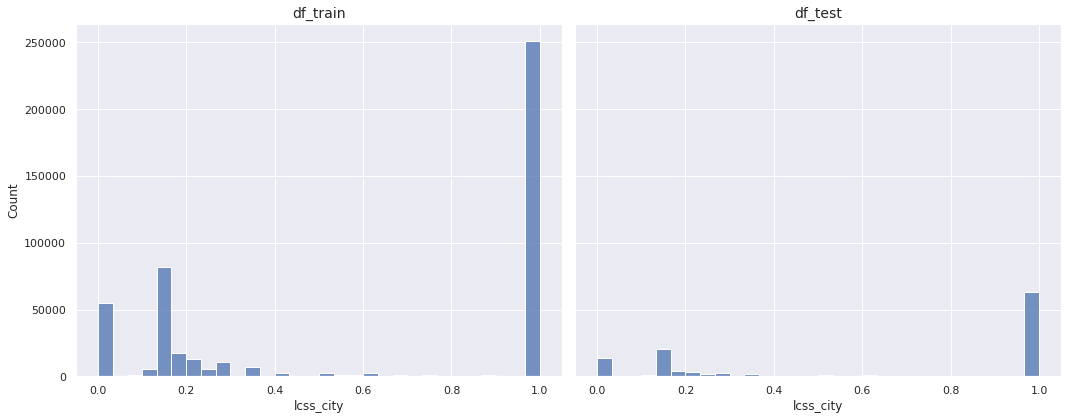

In [36]:
# Histogram of 'lcss_city' for 'df_train' and 'df_test'
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = True)
sns.histplot(data = df_train, x = 'lcss_city', bins = 30, ax = ax[0])
sns.histplot(data = df_test, x = 'lcss_city', bins = 30, ax = ax[1])
ax[0].set_title("df_train", fontsize = 14)
ax[1].set_title("df_test", fontsize = 14)
ax[1].set_ylabel("")
plt.tight_layout()
plt.show()

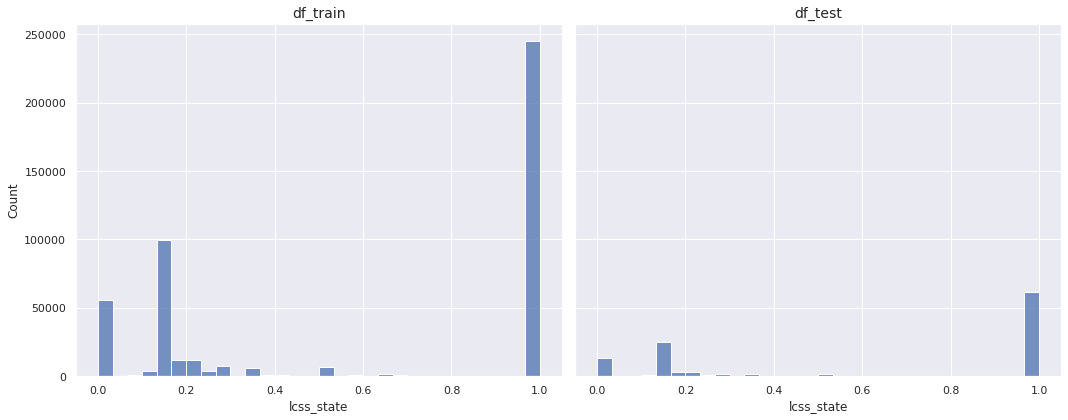

In [37]:
# Histogram of 'lcss_state' for 'df_train' and 'df_test'
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = True)
sns.histplot(data = df_train, x = 'lcss_state', bins = 30, ax = ax[0])
sns.histplot(data = df_test, x = 'lcss_state', bins = 30, ax = ax[1])
ax[0].set_title("df_train", fontsize = 14)
ax[1].set_title("df_test", fontsize = 14)
ax[1].set_ylabel("")
plt.tight_layout()
plt.show()

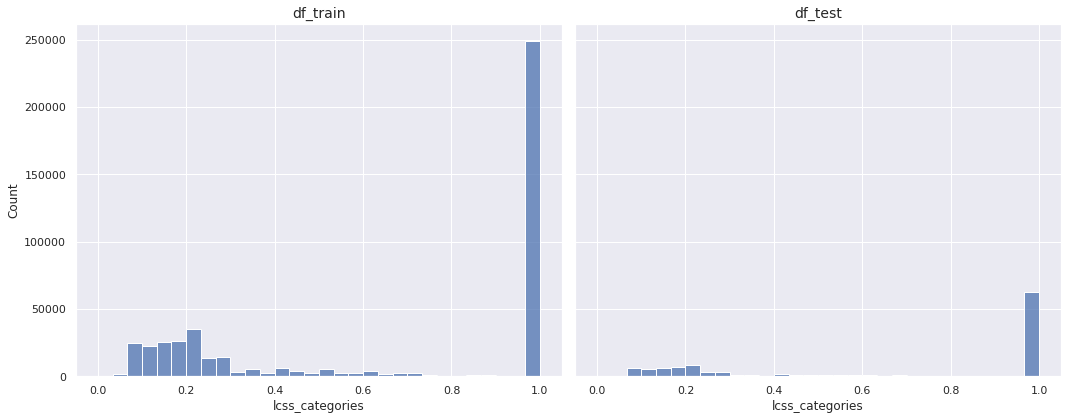

In [38]:
# Histogram of 'lcss_categories' for 'df_train' and 'df_test'
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = True)
sns.histplot(data = df_train, x = 'lcss_categories', bins = 30, ax = ax[0])
sns.histplot(data = df_test, x = 'lcss_categories', bins = 30, ax = ax[1])
ax[0].set_title("df_train", fontsize = 14)
ax[1].set_title("df_test", fontsize = 14)
ax[1].set_ylabel("")
plt.tight_layout()
plt.show()

## Matching of Countries

In [39]:
# Matching of countries
df_train['match_country'] = [float(data_pairs_train['country_1'][i] == data_pairs_train['country_2'][i]) for i in data_pairs_train.index]
df_test['match_country'] = [float(data_pairs_test['country_1'][i] == data_pairs_test['country_2'][i]) for i in data_pairs_test.index]

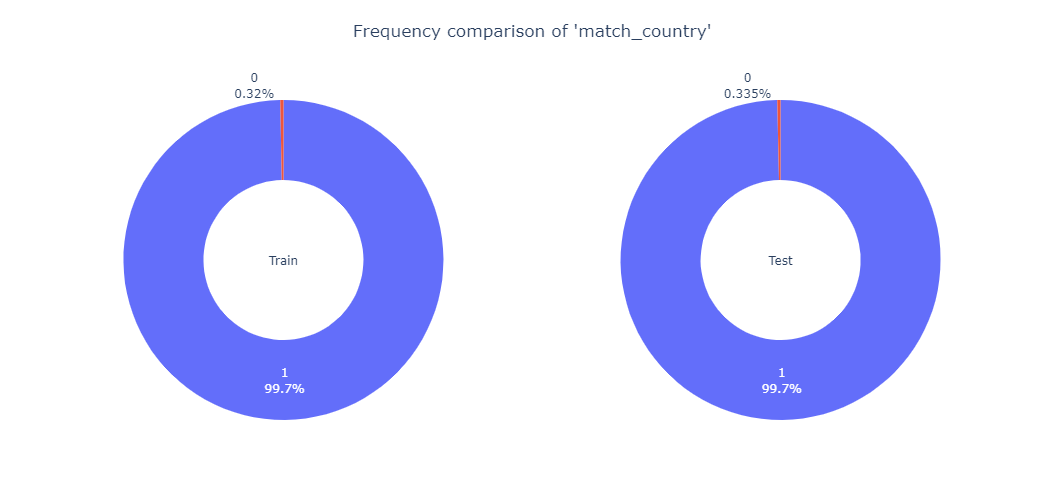

In [40]:
# Donutplots of the 'match_country' column
fig = make_subplots(rows = 1, cols = 2, specs = [[{'type': 'domain'}, {'type': 'domain'}]])
x_val_train = df_train['match_country'].value_counts(sort = False).index.tolist()
y_val_train = df_train['match_country'].value_counts(sort = False).tolist()
x_val_test = df_test['match_country'].value_counts(sort = False).index.tolist()
y_val_test = df_test['match_country'].value_counts(sort = False).tolist()
fig.add_trace(go.Pie(values = y_val_train, labels = x_val_train, hole = 0.5, textinfo = 'label+percent', title = "Train"), row = 1, col = 1)
fig.add_trace(go.Pie(values = y_val_test, labels = x_val_test, hole = 0.5, textinfo = 'label+percent', title = "Test"), row = 1, col = 2)
fig.update_layout(height = 500, width = 800, showlegend = False, xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1), title = dict(text = "Frequency comparison of 'match_country'", x = 0.5, y = 0.95)) 
fig.show()

## The Target Variable

In [41]:
# 'match' column
df_train['match'] = [float(data_pairs_train['match'][i]) for i in data_pairs_train.index]
df_test['match'] = [float(data_pairs_test['match'][i]) for i in data_pairs_test.index]

From this point on, we shall refer to `df_train` as the *effective training set*, or just `training set` and `df_test` as the *effective test set*, or just `test set`. We shall refer to the five-observations-strong `data_test` as the *true test set*.

In [42]:
# Effective training set
print(pd.Series({"Memory usage": "{:.2f} MB".format(df_train.memory_usage().sum()/(1024*1024)),
                 "Dataframe shape": "{}".format(df_train.shape)}).to_string())
print(" ")
df_train.head()

Memory usage          24.73 MB
Dataframe shape    (463125, 7)
 


,dist_loc_transformed,lcss_name,lcss_city,lcss_state,lcss_categories,match_country,match
0,-1.654839,0.421053,0.285714,0.0,1.000000,1.0,1.0
1,-3.610968,1.000000,1.000000,1.0,0.600000,1.0,0.0
2,-1.798537,0.250000,0.000000,0.0,0.054054,1.0,1.0
3,-0.711180,0.375000,0.285714,0.0,0.200000,1.0,0.0
4,-2.346693,0.142857,0.142857,0.5,0.266667,1.0,0.0


In [43]:
# Effective test set
print(pd.Series({"Memory usage": "{:.2f} MB".format(df_test.memory_usage().sum()/(1024*1024)),
                 "Dataframe shape": "{}".format(df_test.shape)}).to_string())
print(" ")
df_test.head()

Memory usage           6.18 MB
Dataframe shape    (115782, 7)
 


,dist_loc_transformed,lcss_name,lcss_city,lcss_state,lcss_categories,match_country,match
0,-5.617429,1.000000,1.000000,1.000000,1.000000,1.0,1.0
1,-2.988849,0.142857,0.000000,0.000000,0.142857,1.0,1.0
2,-3.496262,1.000000,0.142857,0.142857,0.250000,1.0,1.0
3,0.752968,1.000000,0.200000,1.000000,1.000000,1.0,1.0
4,-1.945072,0.777778,1.000000,1.000000,0.142857,1.0,0.0


# 5. Baseline Modeling

- Logistic Regression
- K-Nearest Neighbors
- Decision Tree
- Naive Bayes
- Random Forest
- Linear Discriminant Analysis
- Stochastic Gradient Descent
- Ridge Classifier
- XGBoost
- AdaBoost
- Summary

Each row in `df_train` or `df_test` are of the form $\left(z_1,z_2,\ldots,z_m\right)$, which is essentially a vector representing the differences between two POI observations. Our accomplishment in this section can be summarized by the following transformation:

$$ \left(a_1,a_2,\ldots,a_n; b_1,b_2,\ldots,b_n; y\right) \mapsto \left(z_1,z_2,\ldots,z_m; y\right). $$

Only for pairs generated from training observations, the `match` variable $y$ will be available. The task of modeling is to predict $y$ based on $\left(z_1,z_2,\ldots,z_m\right)$, i.e.

$$ \left(z_1,z_2,\ldots,z_m\right) \mapsto \hat{y} \,\,(\text{estimation of } y). $$

The general plan is to train models on `df_train`, evaluate them on `df_test` and finally apply the best one (according to appropriate evaluation metric) to each distinct, unordered pairs of observations from `data_test` to match the ids.

In [44]:
# Feature-target split
X_train, y_train = df_train.drop('match', axis = 1), df_train['match']
X_test, y_test = df_test.drop('match', axis = 1), df_test['match']

In [45]:
# Function to compute confusion matrix
def conf_mat(y_test, y_pred):
    """
    Computes confusion matrix
    Args:
      y_test (list/array/tuple/set/series): true binary (0/1) labels
      y_pred (list/array/tuple/set/series): predicted binary (0/1) labels
      
    Returns:
      confusion_mat (array): A 2D array representing a 2x2 confusion matrix
    """
    y_test, y_pred = list(y_test), list(y_pred)
    count, labels, confusion_mat = len(y_test), [0, 1], np.zeros(shape = (2, 2), dtype = int)
    for i in range(2):
        for j in range(2):
            confusion_mat[i][j] = len([k for k in range(count) if y_test[k] == labels[i] and y_pred[k] == labels[j]])
    return confusion_mat

In [46]:
# Function to print confusion matrix
def conf_mat_heatmap(y_test, y_pred):
    """
    Prints confusion matrix
    Args:
      y_test (list/array/tuple/set/series): true binary (0/1) labels
      y_pred (list/array/tuple/set/series): predicted binary (0/1) labels
      
    Returns:
      Nothing, prints a heatmap representing a 2x2 confusion matrix
    """
    confusion_mat = conf_mat(y_test, y_pred)
    labels, confusion_mat_df = [0, 1], pd.DataFrame(confusion_mat, range(2), range(2))
    plt.figure(figsize = (6, 4.75))
    # sns.set(font_scale = 1.4) # label size
    sns.heatmap(confusion_mat_df, annot = True, annot_kws = {"size": 16}, fmt = 'd')
    plt.xticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.yticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.xlabel("Predicted label", fontsize = 14)
    plt.ylabel("True label", fontsize = 14)
    plt.title("Confusion Matrix", fontsize = 14)
    plt.grid(False)
    plt.show()

We shall use the *accuracy* measure as an evaluation metric to assess the baseline models. The measure is given by

$$ \text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Number of total predictions}}. $$

In [47]:
# Function to compute accuracy
def accuracy(y_test, y_pred):
    """
    Computes accuracy, given true and predicted binary (0/1) labels
    Args:
      y_test (list/array/tuple/set/series): true binary (0/1) labels
      y_pred (list/array/tuple/set/series): predicted binary (0/1) labels
      
    Returns:
      acc (float): accuracy obtained from y_test and y_pred
    """
    confusion_mat = conf_mat(y_test, y_pred)
    num = confusion_mat[0, 0] + confusion_mat[1, 1]
    denom = num + confusion_mat[0, 1] + confusion_mat[1, 0]
    acc = num / denom
    return acc

In [48]:
# Initiating the summary dictionary
dict_baseline = {}

## Logistic Regression

Model: LogisticRegression(max_iter=1000)
Training accuracy (mean of cross validation scores): 0.7340765459225455
Test accuracy: 0.7352870048884973


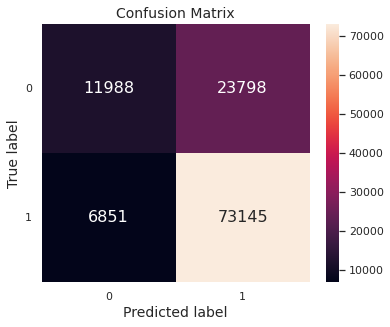

CPU times: user 2min 16s, sys: 1min 42s, total: 3min 58s
Wall time: 1min 1s


In [49]:
%%time
# Logistic regression
logreg = LogisticRegression(max_iter = 1000)
print(f"Model: {logreg}")
cv = RepeatedStratifiedKFold(n_splits = 6, n_repeats = 5, random_state = 1)
print(f"Training accuracy (mean of cross validation scores): {cross_val_score(logreg, X_train, y_train, cv = cv, scoring = 'accuracy').mean()}")
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
score = accuracy(y_test, y_pred)
print(f"Test accuracy: {score}")
dict_baseline['Logistic Regression'] = score
conf_mat_heatmap(y_test, y_pred)

## K-Nearest Neighbors

Model: KNeighborsClassifier(n_jobs=-1, n_neighbors=341)
Training accuracy (mean of cross validation scores): 0.7559034838412111
Test accuracy: 0.75702613532328


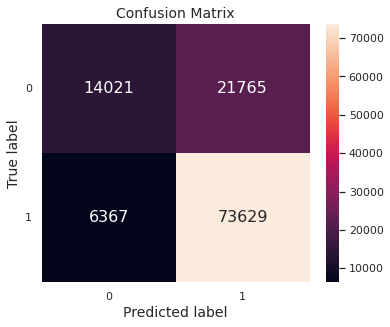

CPU times: user 3min 37s, sys: 36.9 s, total: 4min 14s
Wall time: 9min 26s


In [50]:
%%time
# KNN
k = math.floor(np.sqrt(len(y_test))) + 1
knn = KNeighborsClassifier(n_neighbors = k, n_jobs = -1)
print(f"Model: {knn}")
cv = RepeatedStratifiedKFold(n_splits = 6, n_repeats = 5, random_state = 1)
print(f"Training accuracy (mean of cross validation scores): {cross_val_score(knn, X_train, y_train, cv = cv, scoring = 'accuracy').mean()}")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
score = accuracy(y_test, y_pred)
print(f"Test accuracy: {score}")
dict_baseline['KNN'] = score
conf_mat_heatmap(y_test, y_pred)

## Decision Tree

Model: DecisionTreeClassifier()
Training accuracy (mean of cross validation scores): 0.6823367344458269
Test accuracy: 0.6843550811006892


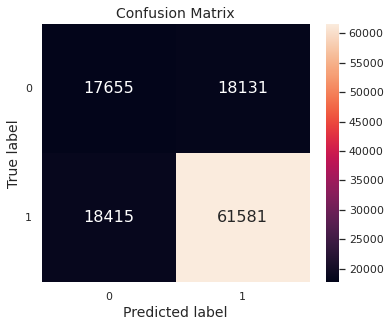

CPU times: user 1min 21s, sys: 985 ms, total: 1min 22s
Wall time: 1min 22s


In [51]:
%%time
# Decision tree
dt = DecisionTreeClassifier()
print(f"Model: {dt}")
cv = RepeatedStratifiedKFold(n_splits = 6, n_repeats = 5, random_state = 1)
print(f"Training accuracy (mean of cross validation scores): {cross_val_score(dt, X_train, y_train, cv = cv, scoring = 'accuracy').mean()}")
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
score = accuracy(y_test, y_pred)
print(f"Test accuracy: {score}")
dict_baseline['Decision Tree'] = score
conf_mat_heatmap(y_test, y_pred)

## Naive Bayes

Model: GaussianNB()
Training accuracy (mean of cross validation scores): 0.6603007813130912
Test accuracy: 0.6590402653262165


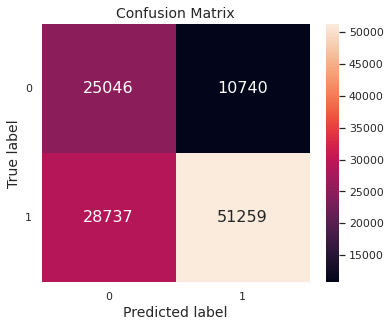

CPU times: user 5.45 s, sys: 180 ms, total: 5.63 s
Wall time: 5.39 s


In [52]:
%%time
# Naive Bayes
nb = GaussianNB()
print(f"Model: {nb}")
cv = RepeatedStratifiedKFold(n_splits = 6, n_repeats = 5, random_state = 1)
print(f"Training accuracy (mean of cross validation scores): {cross_val_score(nb, X_train, y_train, cv = cv, scoring = 'accuracy').mean()}")
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
score = accuracy(y_test, y_pred)
print(f"Test accuracy: {score}")
dict_baseline['Naive Bayes'] = score
conf_mat_heatmap(y_test, y_pred)

## Random Forest

Model: RandomForestClassifier()
Training accuracy (mean of cross validation scores): 0.7226183012899174
Test accuracy: 0.7244735796583234


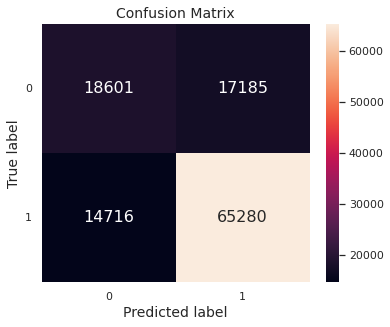

CPU times: user 43min 43s, sys: 21.9 s, total: 44min 5s
Wall time: 44min 12s


In [53]:
%%time
# Random forest
rf = RandomForestClassifier(n_estimators = 100)
print(f"Model: {rf}")
cv = RepeatedStratifiedKFold(n_splits = 6, n_repeats = 5, random_state = 1)
print(f"Training accuracy (mean of cross validation scores): {cross_val_score(rf, X_train, y_train, cv = cv, scoring = 'accuracy').mean()}")
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = accuracy(y_test, y_pred)
print(f"Test accuracy: {score}")
dict_baseline['Random Forest'] = score
conf_mat_heatmap(y_test, y_pred)

## Linear Discriminant Analysis

Model: LinearDiscriminantAnalysis()
Training accuracy (mean of cross validation scores): 0.7335825113998804
Test accuracy: 0.7351142664662901


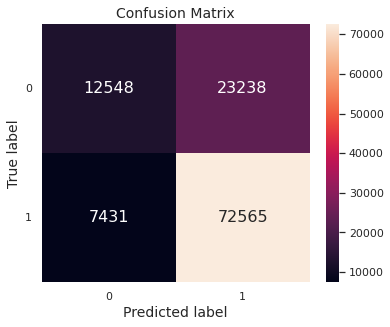

CPU times: user 20.2 s, sys: 9.04 s, total: 29.2 s
Wall time: 16.1 s


In [54]:
%%time
# Linear discriminant analysis
lda = LinearDiscriminantAnalysis()
print(f"Model: {lda}")
cv = RepeatedStratifiedKFold(n_splits = 6, n_repeats = 5, random_state = 1)
print(f"Training accuracy (mean of cross validation scores): {cross_val_score(lda, X_train, y_train, cv = cv, scoring = 'accuracy').mean()}")
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
score = accuracy(y_test, y_pred)
print(f"Test accuracy: {score}")
dict_baseline['LDA'] = score
conf_mat_heatmap(y_test, y_pred)

## Stochastic Gradient Descent

Model: SGDClassifier()
Training accuracy (mean of cross validation scores): 0.7333376510609692
Test accuracy: 0.7357533986284569


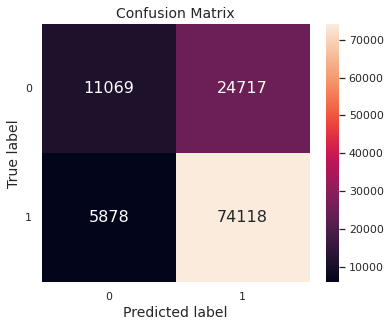

CPU times: user 40.7 s, sys: 7.21 s, total: 47.9 s
Wall time: 36.6 s


In [55]:
%%time
# Stochastic gradient descent
sgd = SGDClassifier(loss = 'hinge')
print(f"Model: {sgd}")
cv = RepeatedStratifiedKFold(n_splits = 6, n_repeats = 5, random_state = 1)
print(f"Training accuracy (mean of cross validation scores): {cross_val_score(sgd, X_train, y_train, cv = cv, scoring = 'accuracy').mean()}")
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
score = accuracy(y_test, y_pred)
print(f"Test accuracy: {score}")
dict_baseline['SGD'] = score
conf_mat_heatmap(y_test, y_pred)

## Ridge Classifier

Model: RidgeClassifier()
Training accuracy (mean of cross validation scores): 0.7336399468749112
Test accuracy: 0.7350538080185176


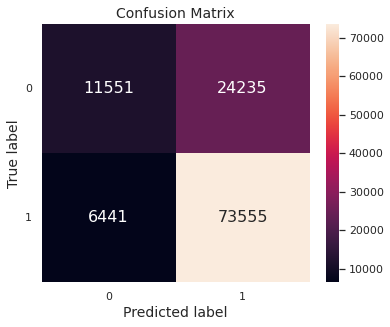

CPU times: user 12.8 s, sys: 7.81 s, total: 20.6 s
Wall time: 8.71 s


In [56]:
%%time
# Ridge
ridge = RidgeClassifier()
print(f"Model: {ridge}")
cv = RepeatedStratifiedKFold(n_splits = 6, n_repeats = 5, random_state = 1)
print(f"Training accuracy (mean of cross validation scores): {cross_val_score(ridge, X_train, y_train, cv = cv, scoring = 'accuracy').mean()}")
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
score = accuracy(y_test, y_pred)
print(f"Test accuracy: {score}")
dict_baseline['Ridge'] = score
conf_mat_heatmap(y_test, y_pred)

## XGBoost

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)
Training accuracy (mean of cross validation scores): 0.7696526891086832
Test accuracy: 0.7712079597864953


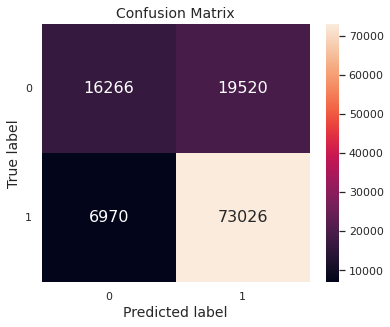

CPU times: user 45min 3s, sys: 4.45 s, total: 45min 7s
Wall time: 11min 38s


In [57]:
%%time
# XGBoost
xgb = XGBClassifier()
print(f"Model: {xgb}")
cv = RepeatedStratifiedKFold(n_splits = 6, n_repeats = 5, random_state = 1)
print(f"Training accuracy (mean of cross validation scores): {cross_val_score(xgb, X_train, y_train, cv = cv, scoring = 'accuracy').mean()}")
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
score = accuracy(y_test, y_pred)
print(f"Test accuracy: {score}")
dict_baseline['XGBoost'] = score
conf_mat_heatmap(y_test, y_pred)

## AdaBoost

Model: AdaBoostClassifier()
Training accuracy (mean of cross validation scores): 0.7551429975496483
Test accuracy: 0.7555837694978494


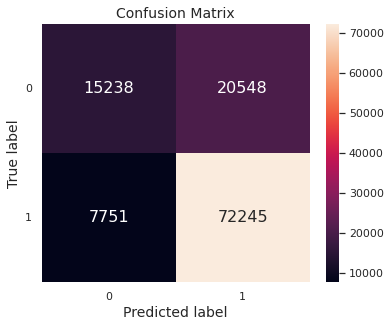

CPU times: user 7min 7s, sys: 290 ms, total: 7min 8s
Wall time: 7min 8s


In [58]:
%%time
# AdaBoost
ada = AdaBoostClassifier()
print(f"Model: {ada}")
cv = RepeatedStratifiedKFold(n_splits = 6, n_repeats = 5, random_state = 1)
print(f"Training accuracy (mean of cross validation scores): {cross_val_score(ada, X_train, y_train, cv = cv, scoring = 'accuracy').mean()}")
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
score = accuracy(y_test, y_pred)
print(f"Test accuracy: {score}")
dict_baseline['AdaBoost'] = score
conf_mat_heatmap(y_test, y_pred)

## Summary

In [59]:
# Summary of the baseline models
df_baseline = pd.DataFrame(dict_baseline.items(), columns = ['Classifier', 'Accuracy'])
df_baseline.sort_values(by = 'Accuracy', ascending = False)

,Classifier,Accuracy
8,XGBoost,0.771208
1,KNN,0.757026
9,AdaBoost,0.755584
6,SGD,0.735753
0,Logistic Regression,0.735287
5,LDA,0.735114
7,Ridge,0.735054
4,Random Forest,0.724474
2,Decision Tree,0.684355
3,Naive Bayes,0.659040


- **XGBoost**, **AdaBoost** (*boosting algorithms*) and **KNN** perform relatively well.

- **Decision Tree**, **Random Forest** (*tree-based algorithms*) and **Naive Bayes** do not work well, compared to the other models. However, these models actually do a better job than the other models in the `0`-class, i.e. the class of pairs for which the true value of `match` is `False` (or `0.0` when converted to float).

# Acknowledgements

- [Foursquare - Location Matching](https://www.kaggle.com/competitions/foursquare-location-matching) competition

# References

- [Case sensitivity](https://en.wikipedia.org/wiki/Case_sensitivity)
- [Correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
- [Foursquare City Guide](https://en.wikipedia.org/wiki/Foursquare_City_Guide)
- [Foursquare Labs Inc.](https://foursquare.com/)
- [Foursquare Swarm](https://en.wikipedia.org/wiki/Foursquare_Swarm)
- [Grove Karl Gilbert](https://en.wikipedia.org/wiki/Grove_Karl_Gilbert)
- [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula)
- [ISO 3166-1 alpha-2](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2)
- [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)
- [Jaccard/Tanimoto similarity test and estimation methods for biological presence-absence data](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3118-5)
- [Jaccard/Tanimoto similarity test and estimation methods (arxiv version)](https://arxiv.org/abs/1903.11372)
- [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance)
- [List of U.S. state and territory abbreviations](https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations)
- [Olympus Mons](https://en.wikipedia.org/wiki/Olympus_Mons)
- [Paul Jaccard](https://en.wikipedia.org/wiki/Paul_Jaccard)
- [Point of Interest](https://en.wikipedia.org/wiki/Point_of_interest)
- [Skewness](https://en.wikipedia.org/wiki/Skewness)
- [Vladimir Levenshtein](https://en.wikipedia.org/wiki/Vladimir_Levenshtein)

In [60]:
# Runtime and memory usage
stop = time.time()
print(pd.Series({"Process runtime": "{:.2f} seconds".format(float(stop - start)),
                 "Process memory usage": "{:.2f} MB".format(float(process.memory_info()[0]/(1024*1024)))}).to_string())

Process runtime         4995.19 seconds
Process memory usage         3691.23 MB
